In [ ]:
#Scanpy: prepocessing and clustering 3k PBMCs

In [32]:
import os 
import pandas as pd
import scanpy as sc

In [34]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.6 louvain==0.8.2 pynndescent==0.5.13


In [38]:
results_file = "write/pbmc3k.h5ad"

In [36]:
pwd

'/Users/juzizhenbutaitian/Desktop/python_sc'

In [46]:
adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",
    var_names = "gene_symbols",
    cache = True,
)

... writing an h5ad cache file to speedup reading next time


In [48]:
adata.var_names_make_unique()

In [52]:
adata.X

<2700x32738 sparse matrix of type '<class 'numpy.float32'>'
	with 2286884 stored elements in Compressed Sparse Column format>

In [ ]:
#Preprocessing

normalizing counts per cell
    finished (0:00:00)


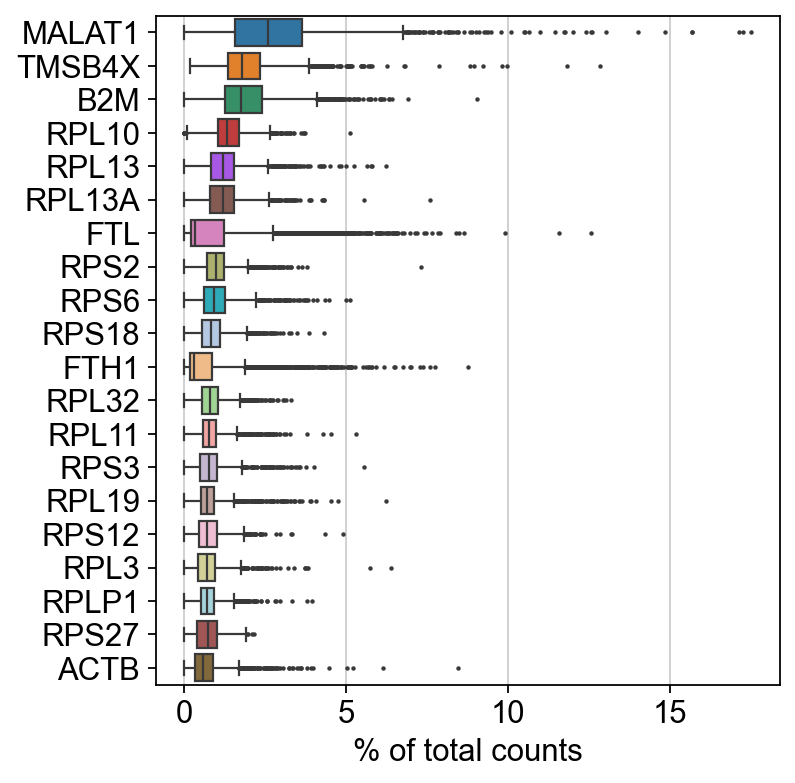

In [54]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [56]:
#Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [58]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

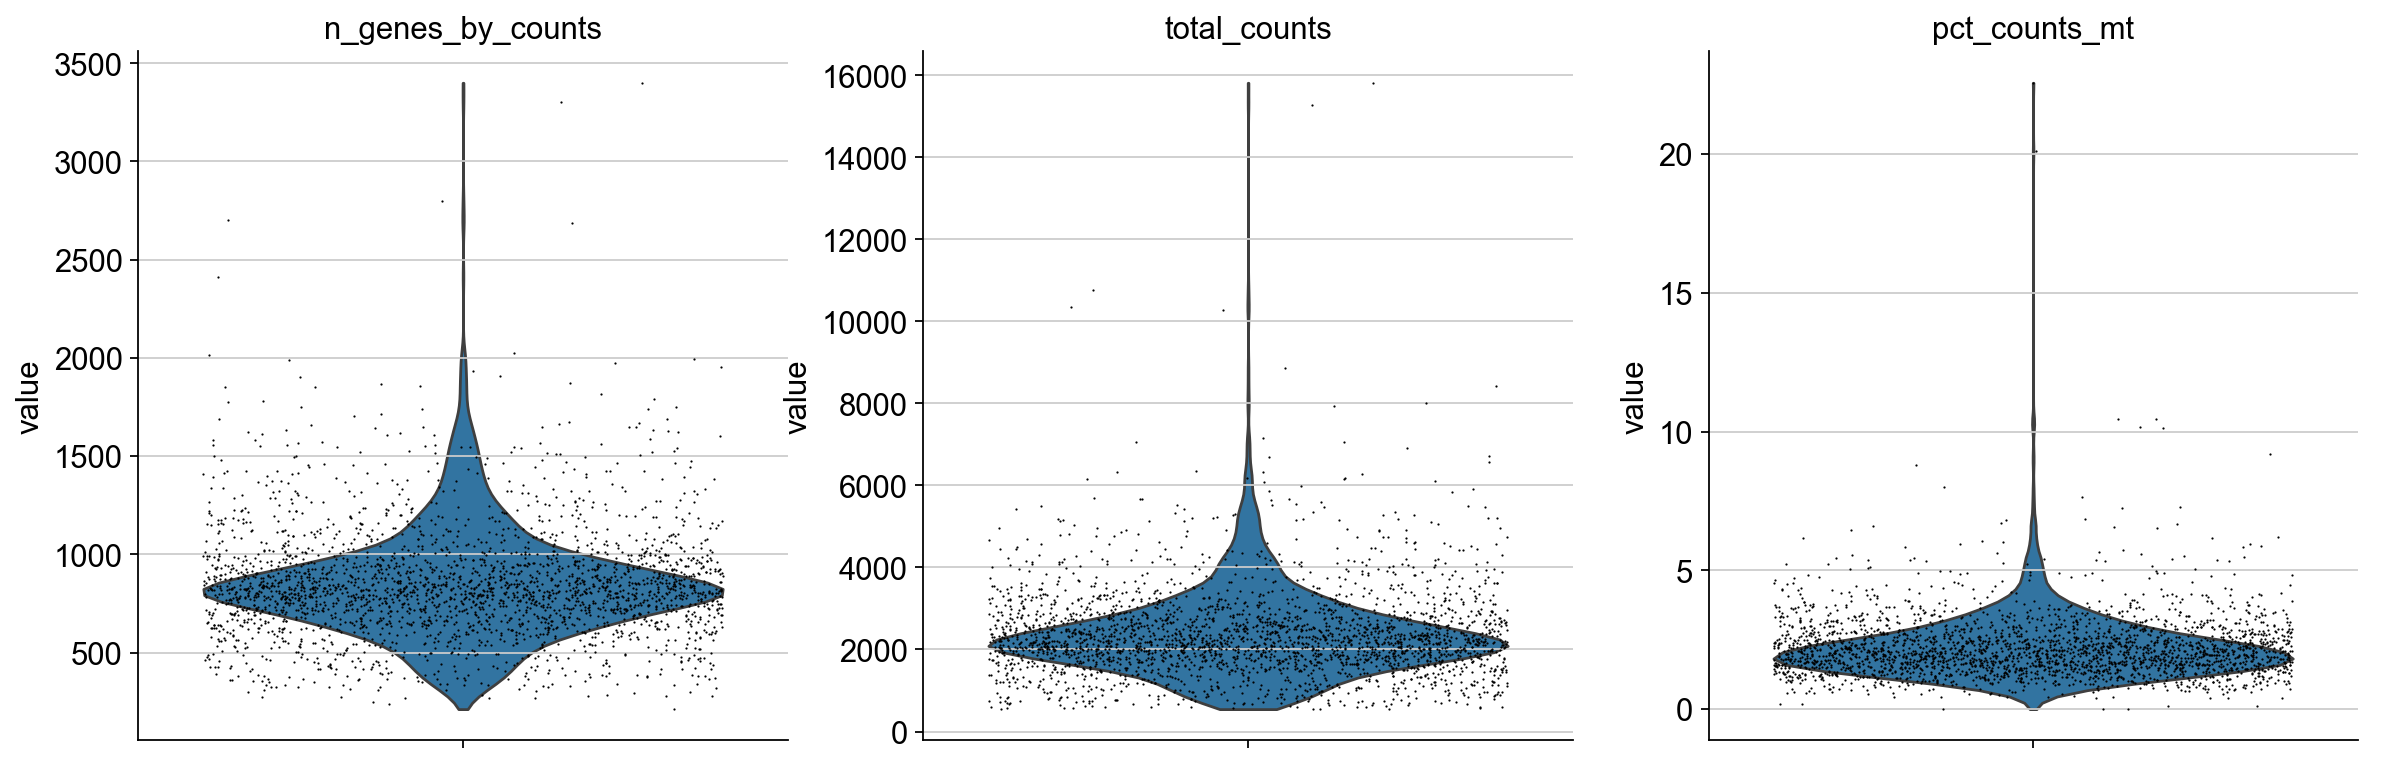

In [60]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

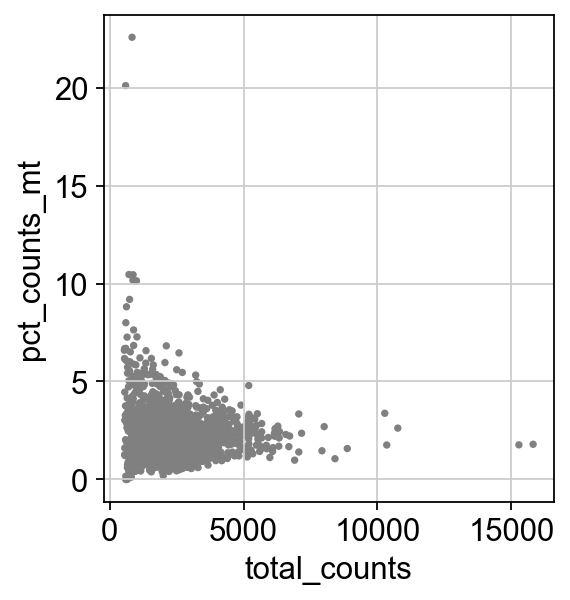

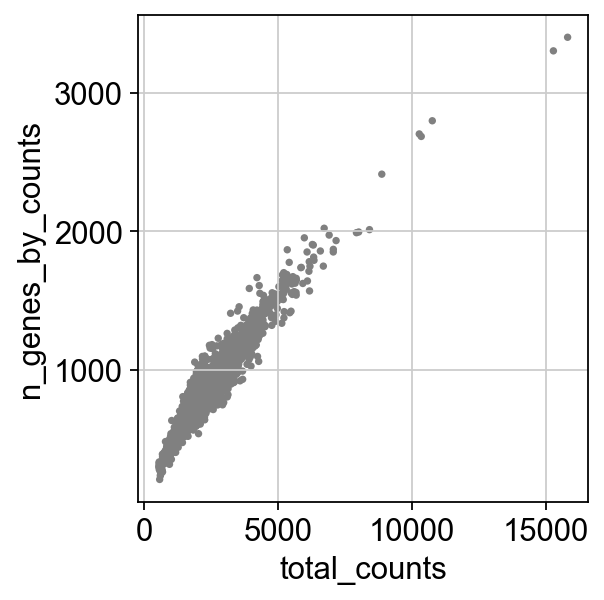

In [62]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [64]:
#filtering by slicing
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [66]:
#Normalization
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [68]:
#Logarithmize
sc.pp.log1p(adata)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


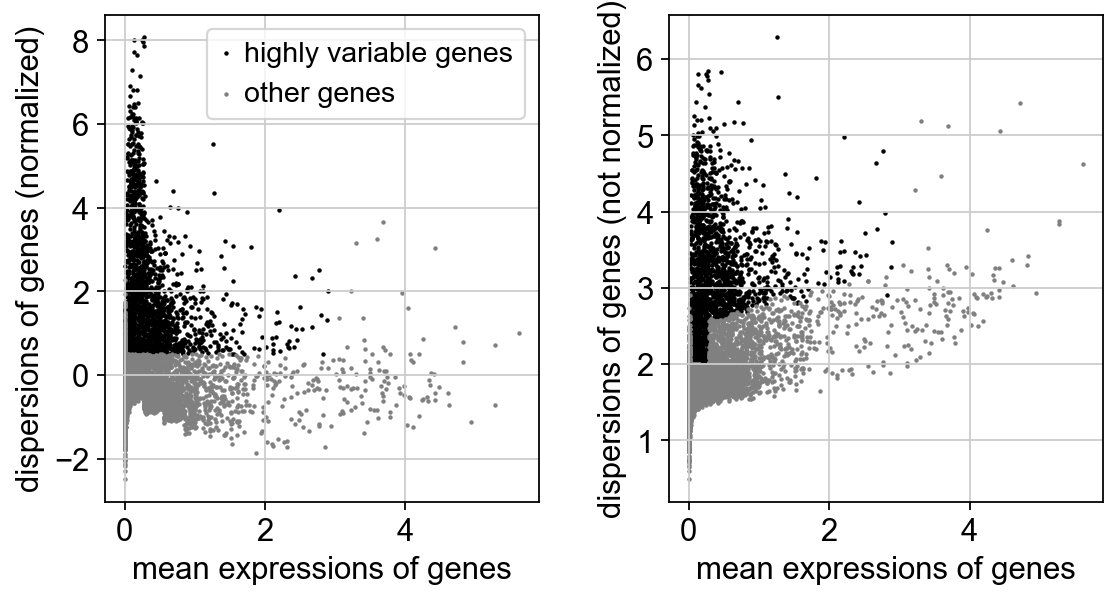

In [72]:
#Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [78]:
# Save the original data
adata.raw = adata

In [80]:
adata = adata[:, adata.var.highly_variable]

In [82]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/opt/anaconda3/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:657: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:10)


In [84]:
sc.pp.scale(adata, max_value=10)

In [ ]:
# PCA

In [86]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:00)


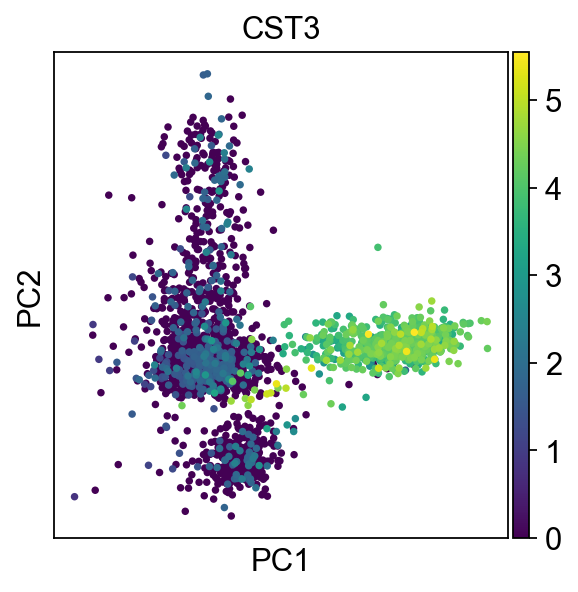

In [88]:
sc.pl.pca(adata, color='CST3')

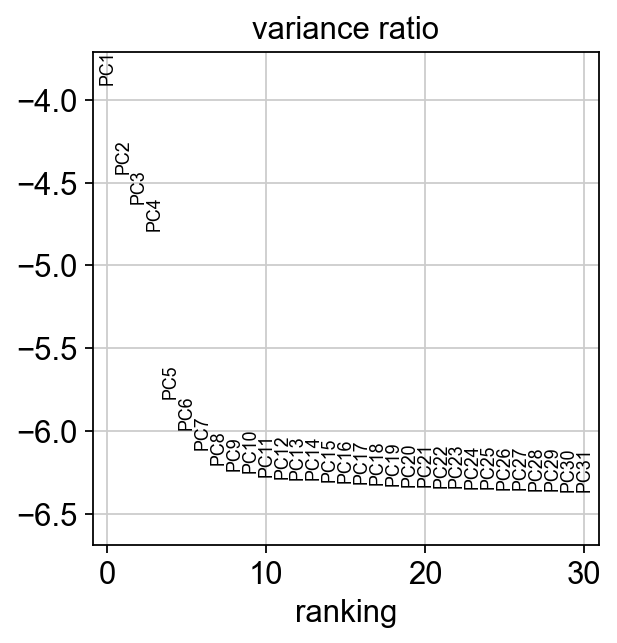

In [90]:
sc.pl.pca_variance_ratio(adata, log=True)

In [94]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [ ]:
#Computing and embedding the neighborhood

In [96]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [102]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


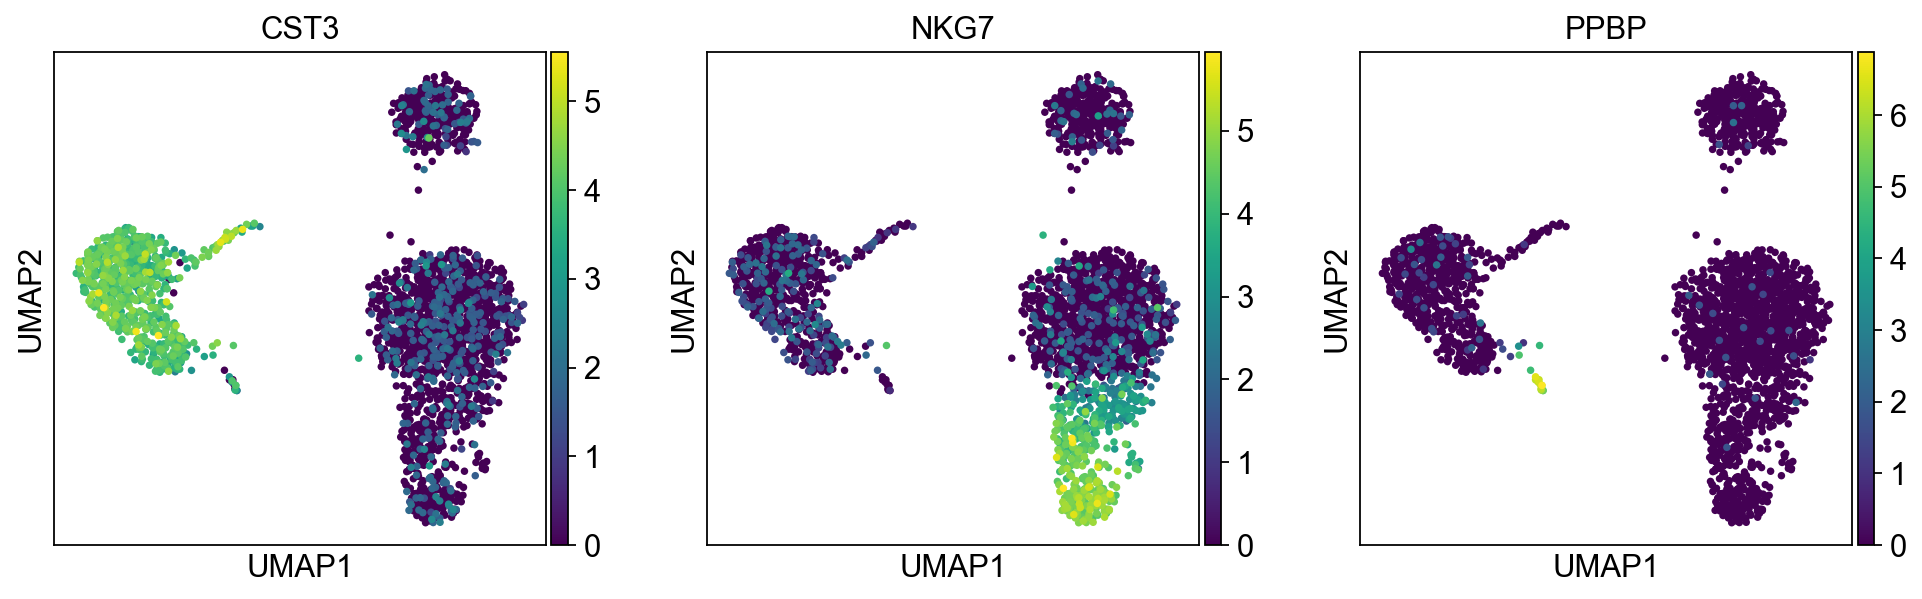

In [104]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])

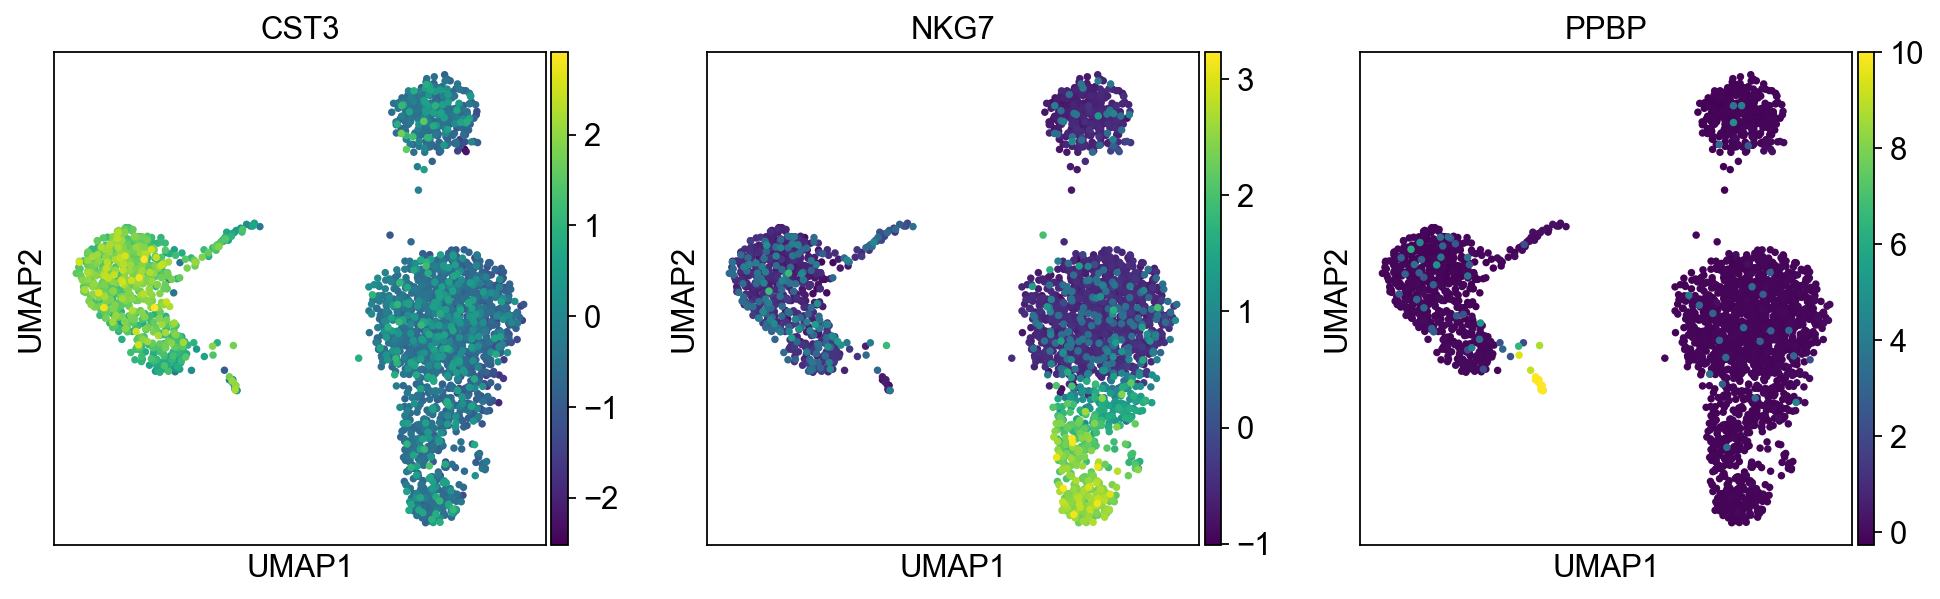

In [106]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], use_raw=False)

In [ ]:
#Clustering the neighborhood

In [130]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


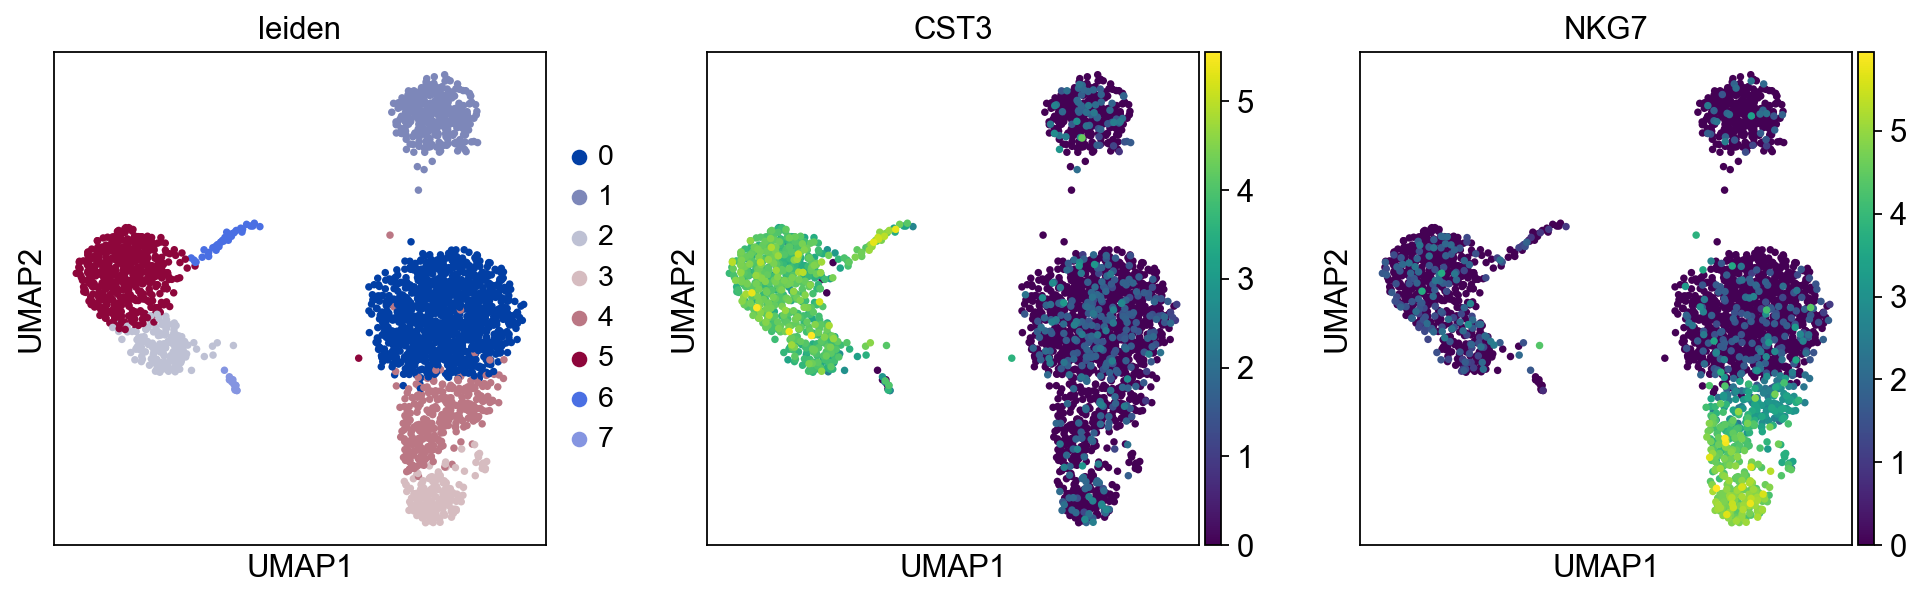

In [132]:
sc.pl.umap(adata, color=["leiden", "CST3", "NKG7"])

In [ ]:
#Finding Markers

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


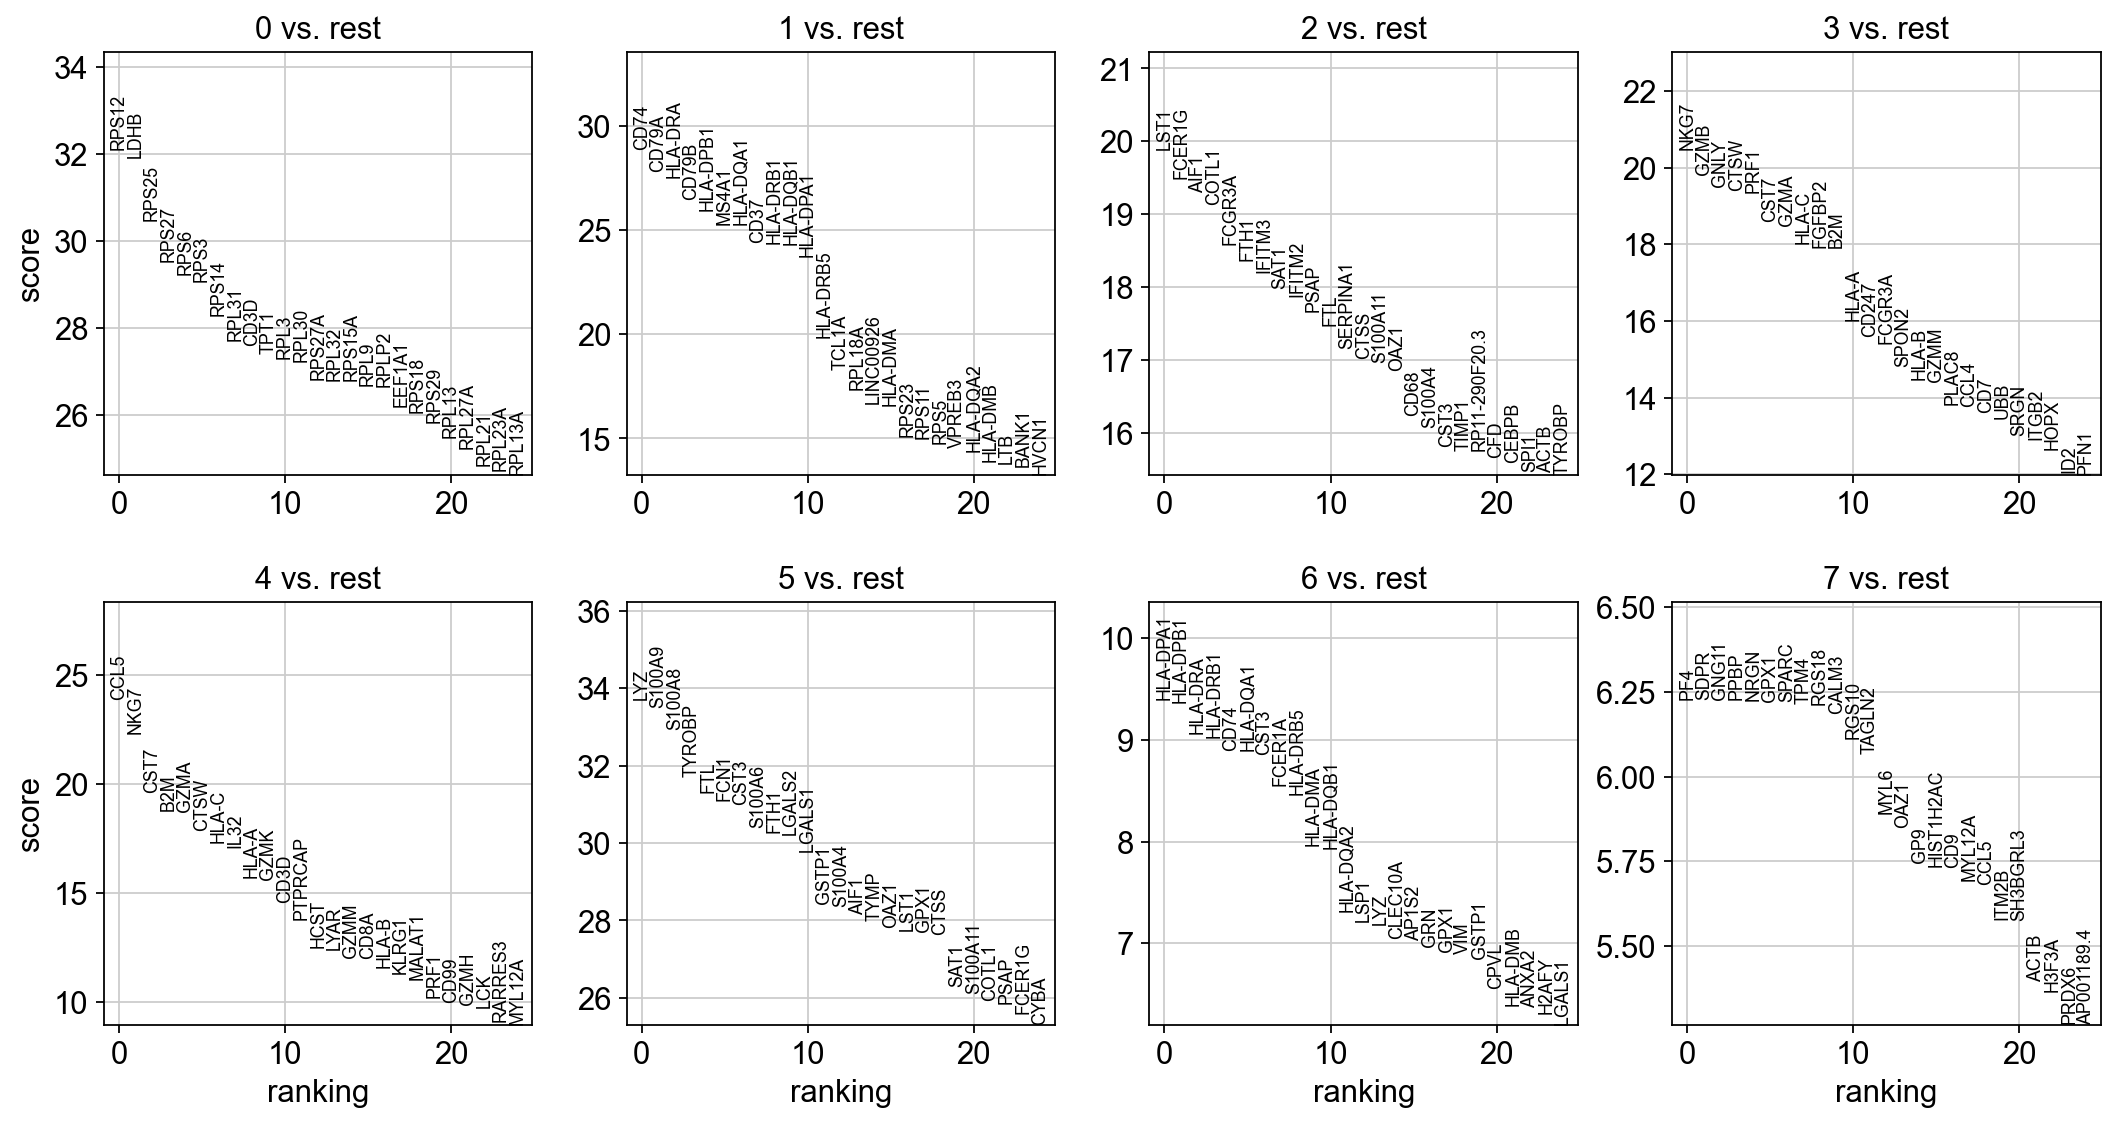

In [136]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [138]:
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

In [140]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

,0,1,2,3,4,5,6,7
0,RPS12,CD74,LST1,NKG7,CCL5,LYZ,HLA-DPA1,PF4
1,LDHB,CD79A,FCER1G,GZMB,NKG7,S100A9,HLA-DPB1,SDPR
2,RPS25,HLA-DRA,AIF1,GNLY,CST7,S100A8,HLA-DRA,GNG11
3,RPS27,CD79B,COTL1,CTSW,B2M,TYROBP,HLA-DRB1,PPBP
4,RPS6,HLA-DPB1,FCGR3A,PRF1,GZMA,FTL,CD74,NRGN


In [142]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,4.167598e-226,CD74,2.487145e-183,LST1,4.985426e-88,NKG7,3.591782e-93,CCL5,4.062586e-126,LYZ,2.844372e-249,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LDHB,1.794807e-223,CD79A,1.679730e-170,FCER1G,1.449472e-84,GZMB,2.033412e-87,NKG7,1.528118e-110,S100A9,2.651928e-246,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,RPS25,4.655800e-204,HLA-DRA,6.935111e-167,AIF1,5.833547e-83,GNLY,8.130223e-85,CST7,1.332168e-85,S100A8,8.731315e-238,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,RPS27,9.438482e-192,CD79B,2.569135e-154,COTL1,1.261406e-81,CTSW,6.944632e-84,B2M,8.615108e-79,TYROBP,9.809633e-221,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,RPS6,5.767118e-188,HLA-DPB1,3.577195e-148,FCGR3A,4.610698e-77,PRF1,1.621421e-83,GZMA,1.480430e-78,FTL,3.676035e-215,CD74,5.853161e-19,NRGN,4.800511e-10


In [ ]:
#Compare to a single cluster

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


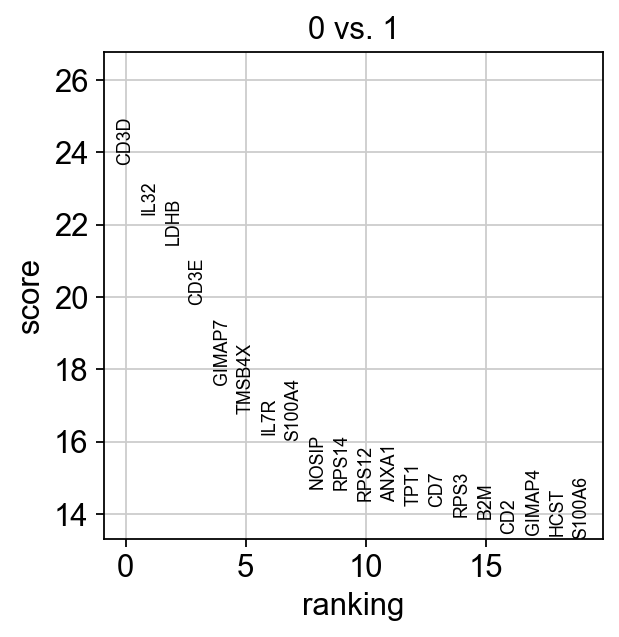

In [144]:
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

/opt/anaconda3/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1320: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


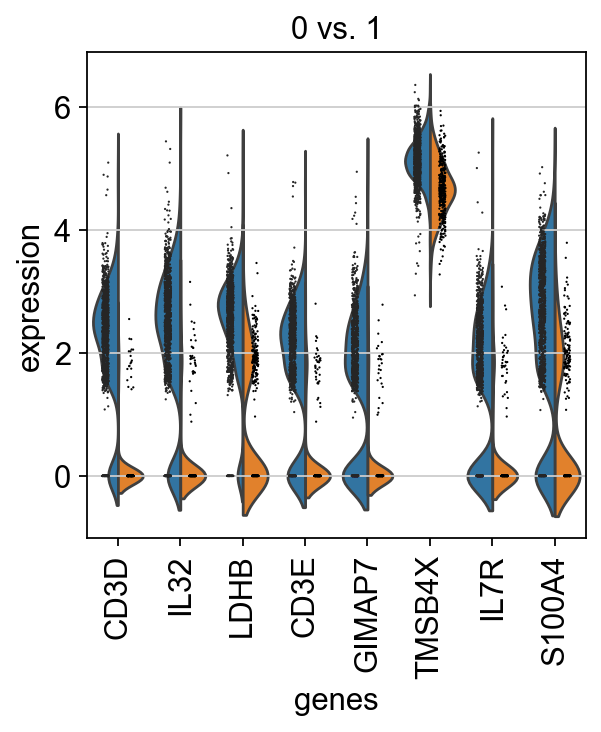

In [146]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

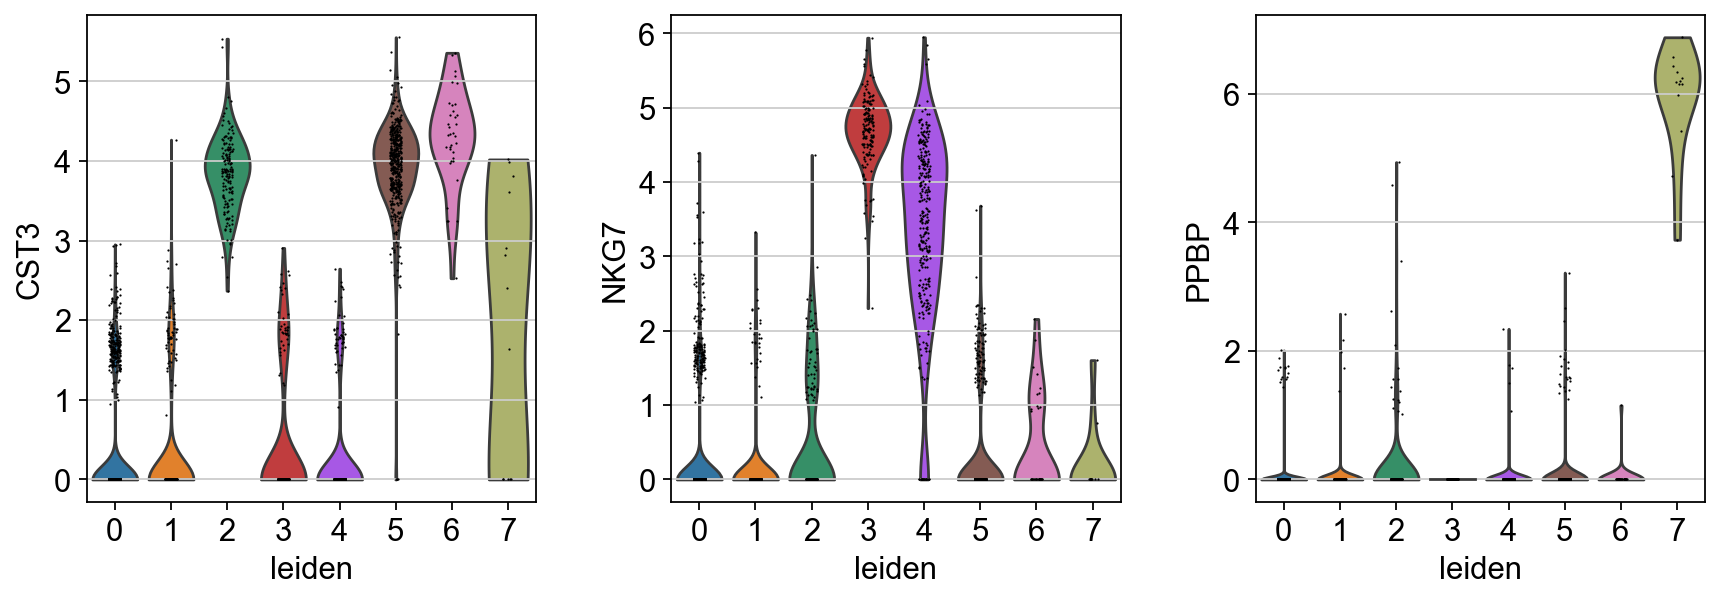

In [150]:
sc.pl.violin(adata, ["CST3", "NKG7", "PPBP"], groupby="leiden")

In [152]:
new_cluster_names = [
    "CD4 T",
    "B",
    "FCGR3A+ Monocytes",
    "NK",
    "CD8 T",
    "CD14+ Monocytes",
    "Dendritic",
    "Megakaryocytes",
]
adata.rename_categories("leiden", new_cluster_names)

Omitting rank_genes_groups/names as old categories do not match.
Omitting rank_genes_groups/scores as old categories do not match.
Omitting rank_genes_groups/pvals as old categories do not match.
Omitting rank_genes_groups/pvals_adj as old categories do not match.
Omitting rank_genes_groups/logfoldchanges as old categories do not match.


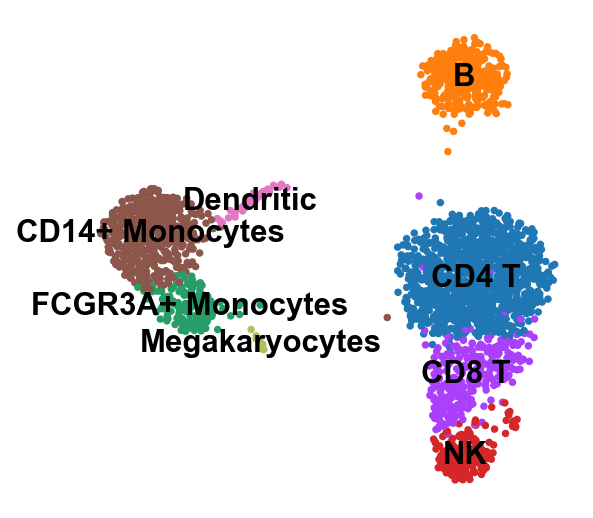

In [158]:
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False
)

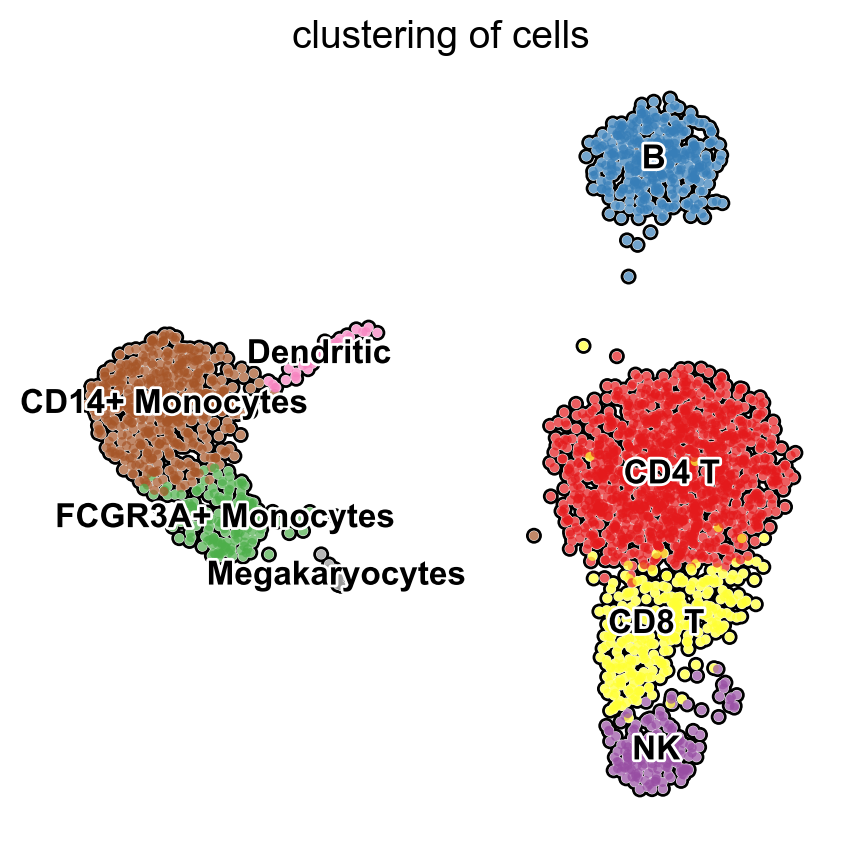

In [182]:
with rc_context({"figure.figsize": (5, 5)}):
    sc.pl.umap(
        adata,
        color="leiden",
        add_outline=True,
        legend_loc="on data",
        legend_fontsize=12,
        legend_fontoutline=2,
        frameon=False,
        title="clustering of cells",
        palette="Set1",
    )

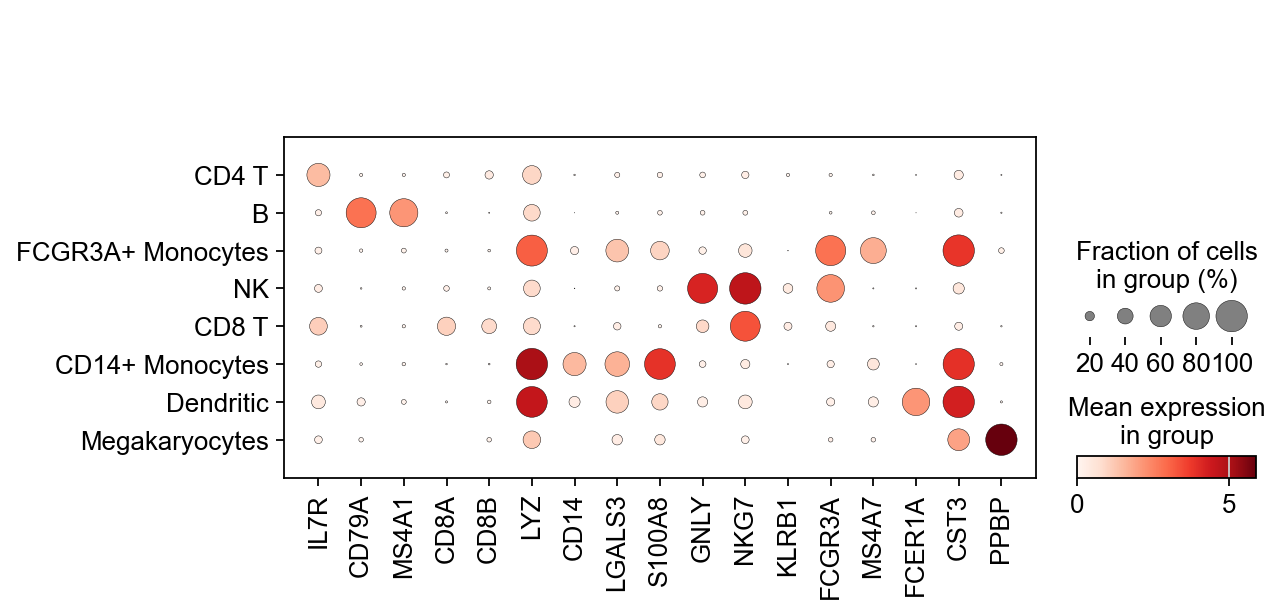

In [160]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden");

In [162]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [166]:
from matplotlib.pyplot import rc_context
sc.set_figure_params(dpi=100, color_map="viridis_r")
sc.settings.verbosity = 0
sc.logging.print_header()

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.6 louvain==0.8.2 pynndescent==0.5.13


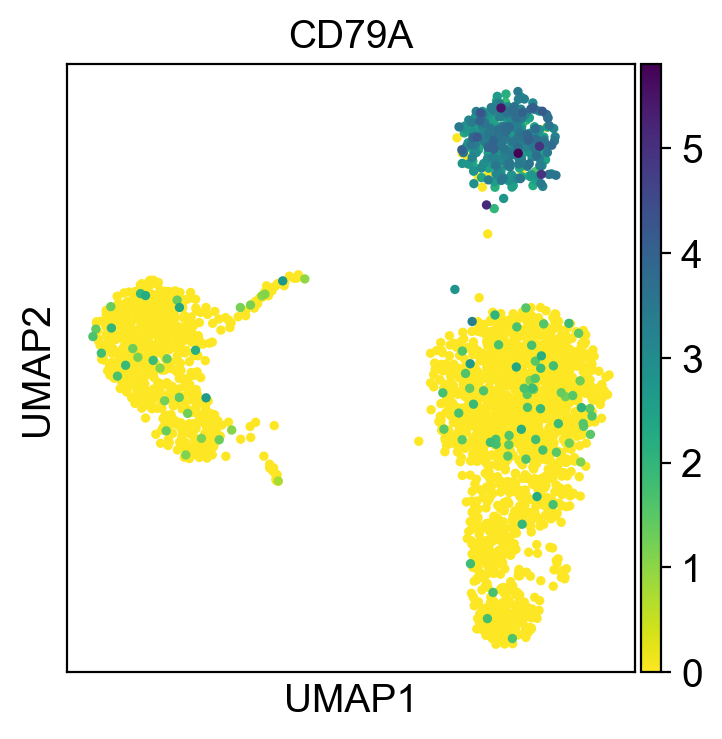

In [170]:
# rc_context is used for the figure size, in this case 4x4
with rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(adata, color="CD79A")